### Introduction
We have recently discussed the need to try and measure both production and efficency within the delivery team. The challenge is to try come up with a metric that we can use to determine if we are doing a better job of delivering work.

### Method

This document is a python notebook I have created so that we can do some statistical analysis on a dataset from the callsheet system and try to find a reasonable metric to quantify production and efficiency.

The challenge is that we are changing how we approach so many things, we are changing all obvious metrics at once. For example, if we had maintained our pricing methodology, it would be easy to define greater production merely by comparing the amount of money chargeable work has brought in. We could use the price to estimate work effort, more money would suggest a bigger job.

We cannot really just look at total time logged as of course this will just go up with the new staff hired, it does not necessarily mean that they produced more useful work in that time period. 

With that in mind I have extracted 2 base reports from informer which I have ran for 3 seperate years (2014, 2015 and 2016) one of which is a detailed dataset of all of the callsheets and the other is aggregated data.

### Callsheets

The simplest starting point is perhaps to just bring in some aggregated data for the 3 years in question and see some crude data for basic comparison. First lets import some libraries to help us work with this data.

In [168]:
# Standard Imports
import numpy as np
import pandas as pd

In [169]:
# Stats Imports
from scipy import stats

In [170]:
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [171]:
%matplotlib inline

Next lets read in our first 3 datasets, the 2014 2015 and 2015 aggreagated data (by month) from some csv files create in informer. This data focuses just on stratum callsheet work. It excludes project callsheets as the majority are for milestone or money tracking only. Analysis of project work will be done later.

In [172]:
cs_agg_2014_df = pd.read_csv('Callsheet Aggregates - 2014.csv')
cs_agg_2015_df = pd.read_csv('Callsheet Aggregates - 2015.csv')
cs_agg_2016_df = pd.read_csv('Callsheet Aggregates - 2016.csv')

Now lets see an example of the aggregated data for 2014 in tabular format.

In [173]:
cs_agg_2014_df

,Closed Month,Time Hours Total (Total),Time Hours Estimated (Total),Quote Time (Total),Count
0,1,498.48,1,152,204
1,2,578.73,0,160,179
2,3,303.19,0,55,157
3,4,243.26,0,95,139
4,5,368.58,0,135,172
5,6,437.10,0,155,138
6,7,1011.67,0,81,138
7,8,216.22,0,53,184
8,9,261.65,0,260,184
9,10,1086.54,0,161,175


#### Comparison of Callsheets Closed
We have similar data for 2015 and the first 2 months of 2016.  We can therefore simply compare the raw count of callsheets for each year by forming a simple bar chart of the information as follows.

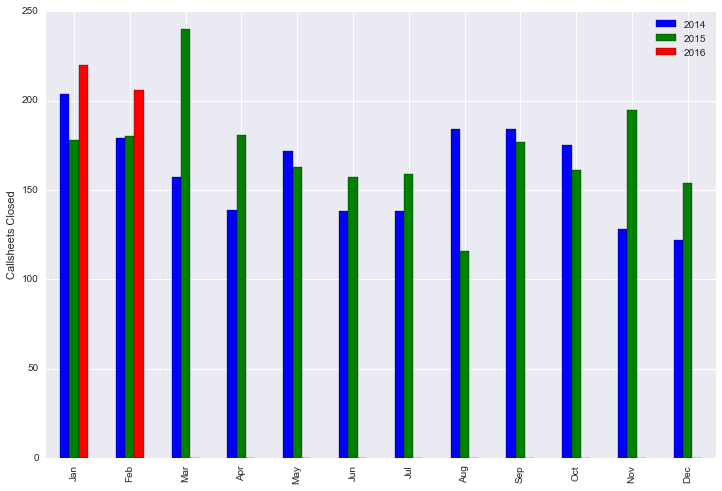

In [178]:
df14 = cs_agg_2014_df[['Count']]
df15 = cs_agg_2015_df[['Count']]
df16 = cs_agg_2016_df[['Count']]
frames = [df14, df15]
df = pd.concat([df14, df15, df16], axis=1, join='outer')
df.columns = ['2014', '2015' , '2016']
ax = df.plot(kind='bar' , figsize=(12, 8))
ax.set_ylabel('Callsheets Closed')
ax.set_xticklabels(('Jan', 'Feb', 'Mar', 'Apr', 'May' , 'Jun' , 'Jul' , 'Aug' , 'Sep' , 'Oct' , 'Nov' , 'Dec'))

So just looking and pure number of callsheets we are, so far closing more calls tan at the same point in the previous 2 years. We are still straining our 3 new developers so I would expect this to improve steadily over the next 3 - 6 months. The main problem with this of course, is that it does not give the picture of the project work. The amount of project work we are able to handle is of the main concern 

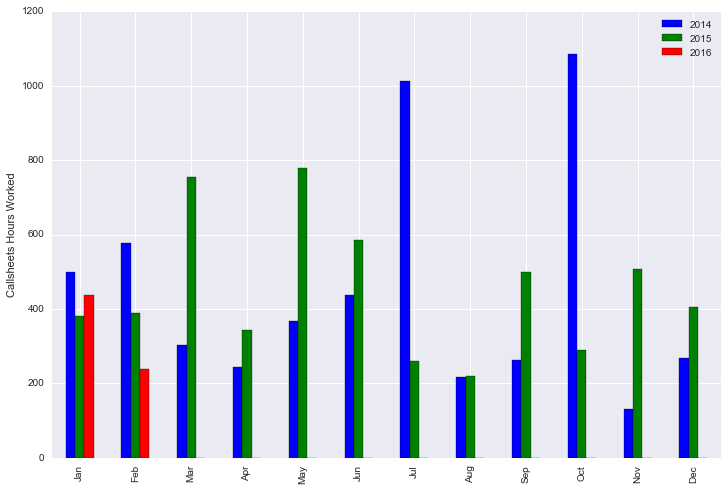

In [181]:
df14 = cs_agg_2014_df[['Time Hours Total (Total)']]
df15 = cs_agg_2015_df[['Time Hours Total (Total)']]
df16 = cs_agg_2016_df[['Time Hours Total (Total)']]
frames = [df14, df15]
df = pd.concat([df14, df15, df16], axis=1, join='outer')
df.columns = ['2014', '2015' , '2016']
ax = df.plot(kind='bar' , figsize=(12, 8))
ax.set_ylabel('Callsheets Hours Worked')
ax.set_xticklabels(('Jan', 'Feb', 'Mar', 'Apr', 'May' , 'Jun' , 'Jul' , 'Aug' , 'Sep' , 'Oct' , 'Nov' , 'Dec'))

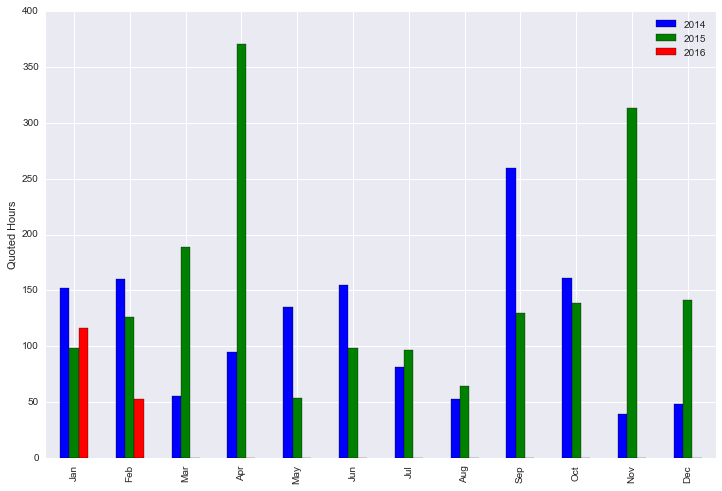

In [183]:
df14 = cs_agg_2014_df[['Quote Time (Total)']]
df15 = cs_agg_2015_df[['Quote Time (Total)']]
df16 = cs_agg_2016_df[['Quote Time (Total)']]
frames = [df14, df15]
df = pd.concat([df14, df15, df16], axis=1, join='outer')
df.columns = ['2014', '2015' , '2016']
ax = df.plot(kind='bar' , figsize=(12, 8))
ax.set_ylabel('Quoted Hours')
ax.set_xticklabels(('Jan', 'Feb', 'Mar', 'Apr', 'May' , 'Jun' , 'Jul' , 'Aug' , 'Sep' , 'Oct' , 'Nov' , 'Dec'))

### Efficiency

In [184]:
dframe = pd.read_csv('Callsheet Open Time.csv')
dframe.tail(10)

,Product Code,Call No,Closed Date,Chargeable,Days With APT,Project Work
4244,SPECTRUM,151854,7 Jan 2015,R,857,N
4245,MS,151785,11 Feb 2015,R,885,Y
4246,MS,151783,15 Sep 2015,Y,893,Y
4247,MS,153310,21 Jul 2015,N,921,N
4248,MS.WEB,149090,7 Jan 2015,U,923,Y
4249,MS,149743,13 Feb 2015,U,923,Y
4250,ISM,148203,27 Mar 2015,N,1011,N
4251,MS,147164,11 Jun 2015,N,1111,N
4252,MS,147792,26 Nov 2015,U,1205,Y
4253,MS,134241,11 Jun 2015,U,1549,NaN


(array([  3.85300000e+03,   1.11000000e+02,   3.60000000e+01,
          1.20000000e+01,   1.20000000e+01,   2.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([ -1.00000000e+00,   1.54000000e+02,   3.09000000e+02,
          4.64000000e+02,   6.19000000e+02,   7.74000000e+02,
          9.29000000e+02,   1.08400000e+03,   1.23900000e+03,
          1.39400000e+03,   1.54900000e+03]),
 <a list of 10 Patch objects>)

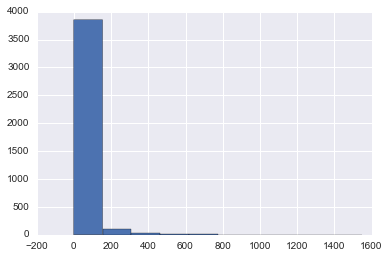

In [185]:
callsheets = dframe[dframe['Project Work'] != 'Y']
cs_days_with_apt = callsheets['Days With APT']
plt.hist(cs_days_with_apt,bins=10)


(array([ 130.,   37.,   17.,   17.,   12.,    5.,    2.,    4.,    0.,    1.]),
 array([    0. ,   120.5,   241. ,   361.5,   482. ,   602.5,   723. ,
          843.5,   964. ,  1084.5,  1205. ]),
 <a list of 10 Patch objects>)

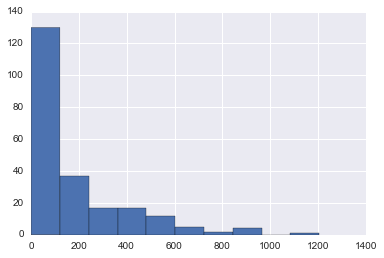

In [186]:
projects = dframe[dframe['Project Work'] == 'Y']
pr_days_with_apt = projects['Days With APT']
plt.hist(pr_days_with_apt,bins=10)
